<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

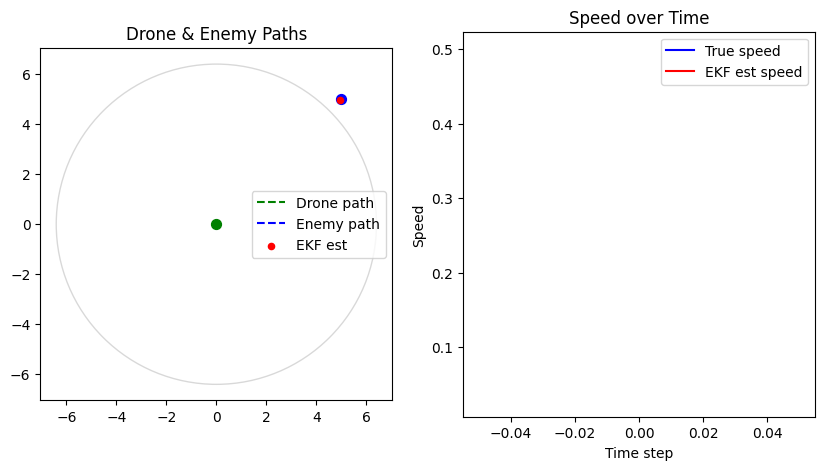

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from google.colab import files
import math

# ===== PARAMETERS =====
np.random.seed(0)
STEPS = 60
MEASUREMENT_NOISE = 0.5
PROCESS_NOISE = 0.2
ENEMY_SPEED = 0.5
DRONE_SPEED = 0.6
MAX_ENEMY_DISTANCE = 8

# ===== INITIAL POSITIONS =====
drone_pos = np.array([0.0, 0.0])
enemy_pos = np.array([5.0, 5.0])

drone_path = [drone_pos.copy()]
enemy_path = [enemy_pos.copy()]
ranges = []

# ===== SIMULATION =====
for _ in range(STEPS):
    # Enemy random movement
    angle = np.random.uniform(0, 2 * np.pi)
    step_vec = ENEMY_SPEED * np.array([np.cos(angle), np.sin(angle)])
    enemy_pos += step_vec

    # Keep enemy within range
    if np.linalg.norm(enemy_pos - drone_pos) > MAX_ENEMY_DISTANCE:
        enemy_pos -= 1.5 * step_vec

    # Drone pursuit
    direction = enemy_pos - drone_pos
    if np.linalg.norm(direction) > 0:
        drone_pos += DRONE_SPEED * direction / np.linalg.norm(direction)

    # Range measurement with noise
    r_meas = np.linalg.norm(enemy_pos - drone_pos) + np.random.normal(0, MEASUREMENT_NOISE)
    ranges.append((drone_pos.copy(), r_meas))

    drone_path.append(drone_pos.copy())
    enemy_path.append(enemy_pos.copy())

drone_path = np.array(drone_path)
enemy_path = np.array(enemy_path)

# ===== EKF FUNCTIONS =====
def ekf_predict(state, P, dt=1.0):
    F = np.eye(4)
    F[0, 2] = dt
    F[1, 3] = dt
    Q = PROCESS_NOISE**2 * np.eye(4)
    state = F @ state
    P = F @ P @ F.T + Q
    return state, P

def ekf_update(state, P, drone_pos, r_meas):
    px, py, vx, vy = state
    dx = px - drone_pos[0]
    dy = py - drone_pos[1]
    dist = math.hypot(dx, dy)
    dist = max(dist, 1e-4)  # Avoid divide-by-zero
    H = np.array([[dx / dist, dy / dist, 0, 0]])
    R = MEASUREMENT_NOISE**2
    y = np.array([r_meas - dist])
    S = H @ P @ H.T + R
    K = P @ H.T @ np.linalg.inv(S)
    state = state + (K @ y).flatten()
    P = (np.eye(4) - K @ H) @ P
    return state, P

# ===== EKF RUN =====
state_est = np.array([enemy_path[0, 0], enemy_path[0, 1], 0, 0])
P_est = np.eye(4)
ekf_estimates, true_speeds, ekf_speeds = [], [], []

for t in range(STEPS):
    state_est, P_est = ekf_predict(state_est, P_est)
    pos_drone, r_meas = ranges[t]
    state_est, P_est = ekf_update(state_est, P_est, pos_drone, r_meas)
    ekf_estimates.append(state_est[:2].copy())

    true_vel = np.linalg.norm(enemy_path[t+1] - enemy_path[t]) if t < STEPS-1 else 0
    ekf_vel = np.linalg.norm(state_est[2:4])
    true_speeds.append(true_vel)
    ekf_speeds.append(ekf_vel)

ekf_estimates = np.array(ekf_estimates)

# ===== ANIMATION =====
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

def update(frame):
    ax1.clear()
    ax2.clear()

    ax1.plot(drone_path[:frame+1, 0], drone_path[:frame+1, 1], 'g--', label='Drone path')
    ax1.plot(enemy_path[:frame+1, 0], enemy_path[:frame+1, 1], 'b--', label='Enemy path')
    ax1.scatter(drone_path[frame, 0], drone_path[frame, 1], c='g', s=50)
    ax1.scatter(enemy_path[frame, 0], enemy_path[frame, 1], c='b', s=50)
    ax1.scatter(ekf_estimates[:frame+1, 0], ekf_estimates[:frame+1, 1], c='r', label='EKF est', s=20)

    # Draw range circles
    for i in range(frame+1):
        circle = plt.Circle(drone_path[i], ranges[i][1], color='gray', fill=False, alpha=0.3)
        ax1.add_patch(circle)

    ax1.legend()
    ax1.set_title('Drone & Enemy Paths')
    ax1.set_aspect('equal')

    ax2.plot(true_speeds[:frame+1], 'b-', label='True speed')
    ax2.plot(ekf_speeds[:frame+1], 'r-', label='EKF est speed')
    ax2.set_title('Speed over Time')
    ax2.set_xlabel('Time step')
    ax2.set_ylabel('Speed')
    ax2.legend()

ani = FuncAnimation(fig, update, frames=STEPS, interval=300, repeat=False)

# ===== SAVE & DOWNLOAD =====
ani.save('drone_tracking.mp4', writer='ffmpeg', fps=5)
files.download('drone_tracking.mp4')

# Show inline
HTML(ani.to_jshtml())


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

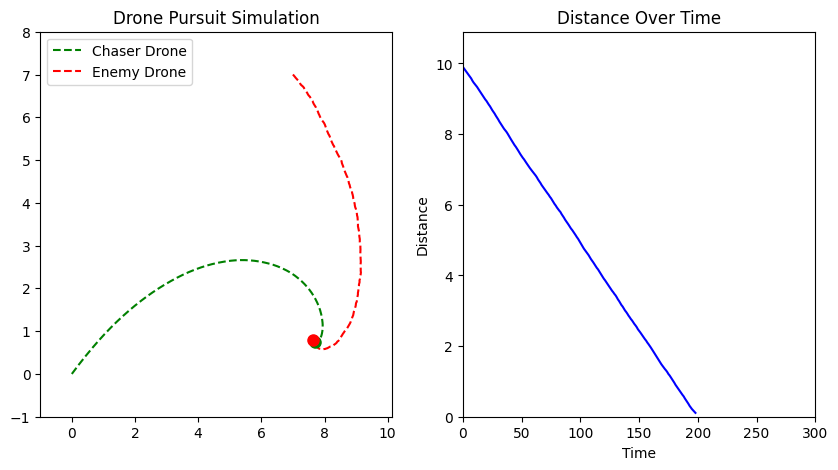

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from google.colab import files

# ===== PARAMETERS =====
TIMESTEPS = 300
DT = 0.1
CHASER_SPEED = 0.05
ENEMY_SPEED = 0.04
CAPTURE_RADIUS = 0.1
PAUSE_FRAMES = 20

np.random.seed(0)

# ===== INITIAL POSITIONS =====
chaser_pos = np.array([0.0, 0.0])
enemy_pos = np.array([7.0, 7.0])

chaser_path = [chaser_pos.copy()]
enemy_path = [enemy_pos.copy()]
distances = []

# ===== SIMULATION =====
for _ in range(TIMESTEPS):
    direction = enemy_pos - chaser_pos
    distance = np.linalg.norm(direction)
    distances.append(distance)

    if distance > CAPTURE_RADIUS:
        direction /= distance
        enemy_move = ENEMY_SPEED * (direction[::-1] * [1, -1])
        enemy_move += (np.random.rand(2) - 0.5) * 0.02
        enemy_pos += enemy_move
        chaser_pos += CHASER_SPEED * direction

    chaser_path.append(chaser_pos.copy())
    enemy_path.append(enemy_pos.copy())

chaser_path = np.array(chaser_path)
enemy_path = np.array(enemy_path)
distances = np.array(distances)

# ===== PLOT SETUP =====
fig, (ax_sim, ax_dist) = plt.subplots(1, 2, figsize=(10, 5))

x_min = min(chaser_path[:, 0].min(), enemy_path[:, 0].min()) - 1
x_max = max(chaser_path[:, 0].max(), enemy_path[:, 0].max()) + 1
y_min = min(chaser_path[:, 1].min(), enemy_path[:, 1].min()) - 1
y_max = max(chaser_path[:, 1].max(), enemy_path[:, 1].max()) + 1

ax_sim.set_xlim(x_min, x_max)
ax_sim.set_ylim(y_min, y_max)
ax_sim.set_title("Drone Pursuit Simulation")

line_chaser, = ax_sim.plot([], [], 'g--', label="Chaser Drone")
line_enemy, = ax_sim.plot([], [], 'r--', label="Enemy Drone")
dot_chaser, = ax_sim.plot([], [], 'go', markersize=8)
dot_enemy, = ax_sim.plot([], [], 'ro', markersize=8)
capture_text = ax_sim.text(0.5, 0.5, '', transform=ax_sim.transAxes,
                           ha='center', va='center',
                           fontsize=14, color='red',
                           bbox=dict(facecolor='white', alpha=0.6, edgecolor='red'))
ax_sim.legend()

ax_dist.set_xlim(0, TIMESTEPS)
ax_dist.set_ylim(0, distances.max() + 1)
ax_dist.set_title("Distance Over Time")
ax_dist.set_xlabel("Time")
ax_dist.set_ylabel("Distance")
line_dist, = ax_dist.plot([], [], 'b-')

# Capture frame detection
capture_frame = next((i for i, d in enumerate(distances) if d < CAPTURE_RADIUS), None)

# ===== UPDATE FUNCTION =====
def update(frame):
    if capture_frame is not None and frame >= capture_frame:
        frame_to_plot = capture_frame
        capture_text.set_text("TARGET CAPTURED" if frame < capture_frame + PAUSE_FRAMES else "")
    else:
        frame_to_plot = frame
        capture_text.set_text("")

    line_chaser.set_data(chaser_path[:frame_to_plot+1, 0], chaser_path[:frame_to_plot+1, 1])
    line_enemy.set_data(enemy_path[:frame_to_plot+1, 0], enemy_path[:frame_to_plot+1, 1])
    dot_chaser.set_data([chaser_path[frame_to_plot, 0]], [chaser_path[frame_to_plot, 1]])
    dot_enemy.set_data([enemy_path[frame_to_plot, 0]], [enemy_path[frame_to_plot, 1]])
    line_dist.set_data(range(frame_to_plot), distances[:frame_to_plot])

    return line_chaser, line_enemy, dot_chaser, dot_enemy, line_dist, capture_text

# ===== ANIMATION =====
ani = animation.FuncAnimation(fig, update, frames=TIMESTEPS + PAUSE_FRAMES,
                              interval=50, blit=True)

ani.save('drone_pursuit.mp4', writer='ffmpeg', fps=20)
files.download('drone_pursuit.mp4')
